In [213]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from FeatureEngineering_2 import *

from joblib import dump, load
from AdvancedModel_helpers import *

In [214]:
# import comet_ml at the top of your file
from comet_ml import Experiment

In [3]:
if not os.path.exists("csv"):
    os.makedirs("csv")
for year in [2016,2017, 2018, 2019]: # 2020 has been excluded to be reserved as the test set
    read_a_season("../nhl_data/",year).to_csv('csv/tidy_{season}.csv'.format(season = year), sep = ',', index = False)

100%|██████████| 6433/6433 [01:05<00:00, 98.80it/s]   


### Consolidating and Sorting CSV Files into a Unified DataFrame

In [215]:
directory = 'csv'

# Get a list of csv file names within the directory
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# Sort the list of csv files
csv_files.sort()

# List to hold your DataFrames
dataframes_list = []

# Loop over the sorted list of csv files with tqdm for progress indication
for filename in tqdm(csv_files, desc="Loading files", unit="file"):
    file_path = os.path.join(directory, filename)
    df = pd.read_csv(file_path)

    # Filter the DataFrame to only include rows where 5th and 6th digits of 'game_id' are '02' (Regular Season)
    df = df[df['game_id'].astype(str).str[4:6] == '02']

    dataframes_list.append(df)

# Concatenate all the DataFrames in the list into a single DataFrame
train_val_df = pd.concat(dataframes_list, ignore_index=True)

# Sort the DataFrame first by 'game_id' and then by 'event_idx'
train_val_df = train_val_df.sort_values(by=['game_id', 'event_idx'])

# Reset the index of the sorted DataFrame
train_val_df = train_val_df.reset_index(drop=True)

Loading files: 100%|██████████| 4/4 [00:01<00:00,  2.91file/s]


In [216]:
train_val_df.head(10)

,game_id,event_idx,play_type,shot_type,shot_dist,game_time,goals_home,goals_away,attack_team_name,period,...,y_coord_last_event,Time_from_the_last_event,Distance_from_the_last_event,Rebound,change_shot_angle,Speed,x,y,angle_net,is_goal
0,2016020001,9,Shot,Wrist Shot,13.000000,71,0,0,Toronto Maple Leafs,1,...,11.0,1,17.088007,False,NaN,17.088007,-77.0,5.0,-22.619865,0
1,2016020001,16,Shot,Wrist Shot,13.341664,173,0,0,Ottawa Senators,1,...,-5.0,5,36.715120,False,NaN,7.343024,86.0,13.0,77.005383,0
2,2016020001,23,Shot,Wrist Shot,76.157731,241,0,0,Ottawa Senators,1,...,0.0,18,102.318131,False,NaN,5.684341,23.0,-38.0,-29.931512,0
3,2016020001,25,Shot,Slap Shot,57.974132,286,0,0,Ottawa Senators,1,...,-2.0,19,45.880279,False,NaN,2.414752,33.0,-15.0,-14.995079,0
4,2016020001,38,Shot,Wrist Shot,61.717096,406,0,0,Toronto Maple Leafs,1,...,34.0,16,81.221918,False,NaN,5.076370,-34.0,28.0,-26.980231,0
5,2016020001,40,Shot,Wrist Shot,58.523500,450,0,0,Toronto Maple Leafs,1,...,31.0,23,48.041649,False,NaN,2.088767,-33.0,-17.0,16.886791,0
6,2016020001,43,Goal,Wrist Shot,19.026298,501,0,1,Toronto Maple Leafs,1,...,-8.0,3,17.492856,False,NaN,5.830952,-70.0,1.0,-3.012788,1
7,2016020001,45,Shot,Wrist Shot,56.850682,509,0,1,Toronto Maple Leafs,1,...,0.0,8,57.628118,False,NaN,7.203515,-45.0,-36.0,39.289407,0
8,2016020001,48,Shot,Slap Shot,58.821765,540,0,1,Ottawa Senators,1,...,-22.0,30,102.078401,False,NaN,3.402613,33.0,-18.0,-17.818889,0
9,2016020001,59,Shot,Wrist Shot,58.523500,616,0,1,Ottawa Senators,1,...,22.0,5,35.057096,False,NaN,7.011419,34.0,20.0,19.983107,0


In [217]:
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.calibration import CalibrationDisplay

### Training and Validation sets split

### 1. Train with only **Distance** and **Angle**

In [218]:
# Create an experiment with your api key
exp = Experiment(
    api_key="v5q8O8LftZtvOcoXlVM8Ku8fH",
    project_name="ift6758",
    workspace="hfereidouni",
)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: xgboost, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/hfereidouni/ift6758/e0a5aa92457347cb8d4f817f7697747b



#### 1.1 Training and Validating

In [219]:
train_X_1,train_Y_1,val_X_1,val_Y_1 = split_data(train_val_df,['shot_dist','angle_net'],0.25,True)
train_X_1

,shot_dist,angle_net
205686,54.037024,2.000000
254511,46.529560,28.000000
258329,60.406953,19.000000
215078,54.037024,2.000000
54982,40.804412,36.027373
...,...,...
217653,57.697487,-25.000000
87384,59.008474,0.000000
125109,46.754679,-48.000000
156101,47.801674,37.000000


In [220]:
xgboost1= XGBClassifier()
xgboost1.fit(train_X_1, train_Y_1)
xgboost1_path = './models/xgboost1.joblib'
dump(xgboost1,xgboost1_path)

['./models/xgboost1.joblib']

#### 1.2

##### ROC AUC

{'web': 'https://www.comet.com/api/image/download?imageId=0d67fcbe3d31448197fc0df13eb616f7&experimentKey=e0a5aa92457347cb8d4f817f7697747b',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=0d67fcbe3d31448197fc0df13eb616f7&experimentKey=e0a5aa92457347cb8d4f817f7697747b',
 'imageId': '0d67fcbe3d31448197fc0df13eb616f7'}

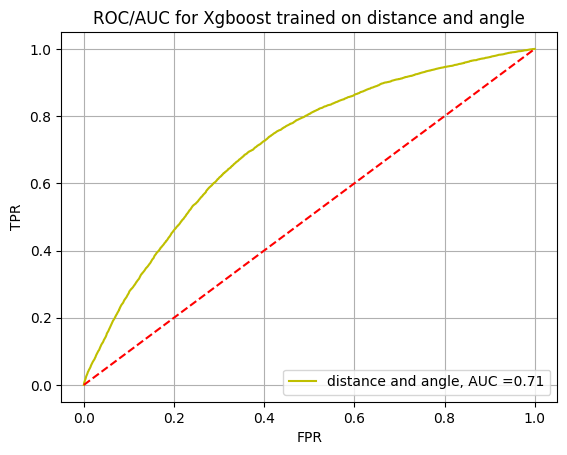

In [221]:
xgboost1=load(xgboost1_path)
val_res = xgboost1.predict_proba(val_X_1)
fpr,tpr,threshold,roc_auc_score = roc_auc_plot(val_Y_1,val_res,'Xgboost','distance and angle')
exp.log_figure(figure_name='ROC/AUC Xgboost trained on distance and angle with no hp tuning')

In [222]:
metrics_1 = {
    'class_probabilities':val_res,
    'validation_accuracy': metrics.accuracy_score(xgboost1.predict(val_X_1), val_Y_1),
    'AUC_score':roc_auc_score,
             }
exp.log_metrics(metrics_1, step=1)

COMET WARNING: Cannot safely convert array([[0.82241225, 0.17758772],
       [0.8434984 , 0.15650159],
       [0.83383596, 0.16616401],
       ...,
       [0.9111359 , 0.0888641 ],
       [0.9218376 , 0.07816235],
       [0.9499217 , 0.05007828]], dtype=float32) object to a scalar value, using its string representation for logging. Resulting string might be invalid


In [223]:
precision_1 = metrics.precision_score(val_Y_1,xgboost1.predict(val_X_1))
recall_1= metrics.recall_score(val_Y_1,xgboost1.predict(val_X_1))

##### Goal rate

In [224]:
probas_and_label = helper_df(val_Y_1,val_res)
probas_and_label

,is_goal,goal_proba,#goal+#shot,#goal,#goal/#goal+#shot,rank,goal_prob_sum,goal_prob_cumulative_sum,cum_percent
25798,0,0.583065,1,0.0,0.000000,99.999324,1.164055e+06,0.000000e+00,0.000000
16073,1,0.583065,2,0.0,0.000000,99.999324,1.164055e+06,0.000000e+00,0.000000
284628,0,0.573995,3,1.0,33.333333,99.995269,1.164055e+06,3.333333e+01,0.002864
77118,1,0.573995,4,1.0,25.000000,99.995269,1.164055e+06,5.833333e+01,0.005011
240356,1,0.573995,5,2.0,40.000000,99.995269,1.164055e+06,9.833333e+01,0.008447
...,...,...,...,...,...,...,...,...,...
172248,0,0.002033,73972,6967.0,9.418429,0.008787,1.164055e+06,1.164018e+06,99.996764
205038,0,0.002033,73973,6967.0,9.418301,0.008787,1.164055e+06,1.164027e+06,99.997573
6850,0,0.002033,73974,6967.0,9.418174,0.008787,1.164055e+06,1.164037e+06,99.998382
288496,0,0.001412,73975,6967.0,9.418047,0.002028,1.164055e+06,1.164046e+06,99.999191


{'web': 'https://www.comet.com/api/image/download?imageId=41853ffde09443398fb4907ff9c5eab4&experimentKey=e0a5aa92457347cb8d4f817f7697747b',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=41853ffde09443398fb4907ff9c5eab4&experimentKey=e0a5aa92457347cb8d4f817f7697747b',
 'imageId': '41853ffde09443398fb4907ff9c5eab4'}

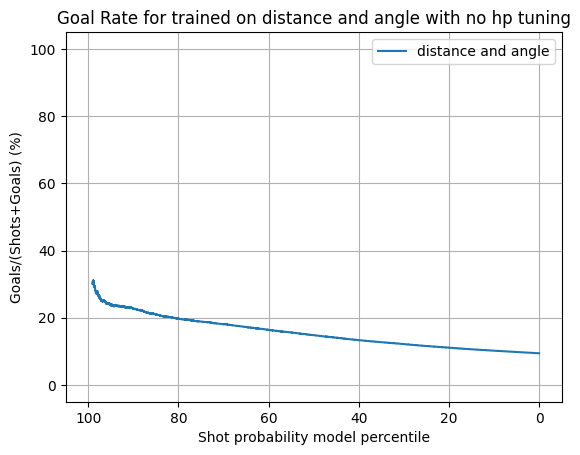

In [225]:
start_length = int(len(probas_and_label)*0.01)
plt.plot(probas_and_label['rank'].iloc[start_length:],probas_and_label['#goal/#goal+#shot'].iloc[start_length:],label="distance and angle")
plt.title(f'Goal Rate for trained on distance and angle with no hp tuning')
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Goals/(Shots+Goals) (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()
exp.log_figure(figure_name='Goal Rate for trained on distance and angle with no hp tuning')

{'web': 'https://www.comet.com/api/image/download?imageId=b7d6cd104bec42f795941a7a01008e89&experimentKey=e0a5aa92457347cb8d4f817f7697747b',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=b7d6cd104bec42f795941a7a01008e89&experimentKey=e0a5aa92457347cb8d4f817f7697747b',
 'imageId': 'b7d6cd104bec42f795941a7a01008e89'}

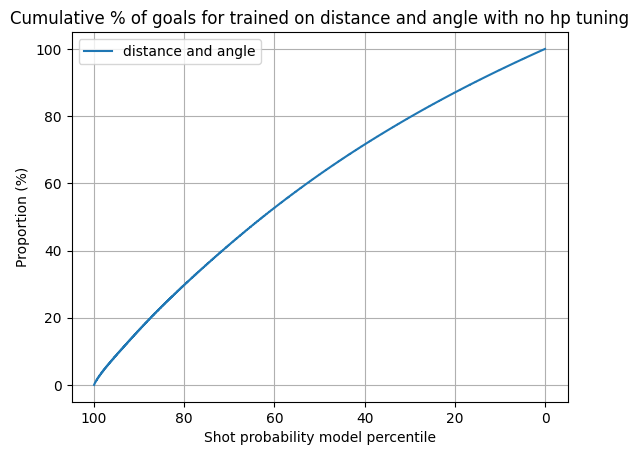

In [226]:
plt.plot(probas_and_label['rank'],probas_and_label['cum_percent'],label="distance and angle")
plt.title(f'Cumulative % of goals for trained on distance and angle with no hp tuning')
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Proportion (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()
exp.log_figure(figure_name='Cumulative % of goals for trained on distance and angle with no hp tuning')

{'web': 'https://www.comet.com/api/image/download?imageId=60e818e42dd847d29d21a96a8b6ce9b6&experimentKey=e0a5aa92457347cb8d4f817f7697747b',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=60e818e42dd847d29d21a96a8b6ce9b6&experimentKey=e0a5aa92457347cb8d4f817f7697747b',
 'imageId': '60e818e42dd847d29d21a96a8b6ce9b6'}

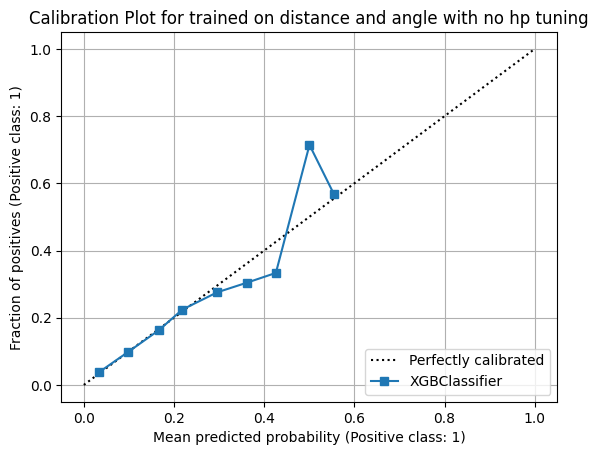

In [227]:
disp = CalibrationDisplay.from_estimator(xgboost1,val_X_1,val_Y_1,n_bins=15)
plt.title("Calibration Plot for trained on distance and angle with no hp tuning")
plt.grid(True)
exp.log_figure(figure_name="Calibration Plot for trained on distance and angle with no hp tuning")

In [228]:
exp.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/hfereidouni/ift6758/e0a5aa92457347cb8d4f817f7697747b
COMET INFO:   Metrics:
COMET INFO:     AUC_score           : 0.7106202416487704
COMET INFO:     class_probabilities : [[0.82241225 0.17758772]
 [0.8434984  0.15650159]
 [0.83383596 0.16616401]
 ...
 [0.9111359  0.0888641 ]
 [0.9218376  0.07816235]
 [0.9499217  0.05007828]]
COMET INFO:     validation_accuracy : 0.9059019141343139
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     figures          

### 2. Train with **features in part4**

In [229]:
# Create an experiment with your api key
exp = Experiment(
    api_key="v5q8O8LftZtvOcoXlVM8Ku8fH",
    project_name="ift6758",
    workspace="hfereidouni",
)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: xgboost, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/hfereidouni/ift6758/cd4cdf2f3d6a47dc8a58b25261ed7c27



In [230]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from bayes_opt import BayesianOptimization

In [231]:
train_val_df_2=train_val_df[['game_time','period','x','y','shot_type','last_event_type',
       'x_coord_last_event', 'y_coord_last_event', 'Time_from_the_last_event',
       'Distance_from_the_last_event', 'Rebound', 'change_shot_angle', 'Speed',
       'angle_net', 'is_goal']]

##### One hot encoding 

In [232]:
train_val_2_shot_type_oh = onehot_generator(train_val_df_2[['shot_type']])
train_val_2_last_event_type_oh = onehot_generator(train_val_df_2[['last_event_type']])

In [233]:
train_val_df_2= train_val_df_2.drop(columns=['shot_type','last_event_type'])
train_val_df_2 = pd.concat([train_val_df_2,
                       train_val_2_shot_type_oh.set_index(train_val_df_2.index),
                       train_val_2_last_event_type_oh.set_index(train_val_df_2.index)],axis=1)

In [234]:
train_val_df_2

,game_time,period,x,y,x_coord_last_event,y_coord_last_event,Time_from_the_last_event,Distance_from_the_last_event,Rebound,change_shot_angle,...,last_event_type_Missed Shot,last_event_type_Official Challenge,last_event_type_Penalty,last_event_type_Period End,last_event_type_Period Ready,last_event_type_Period Start,last_event_type_Shootout Complete,last_event_type_Shot,last_event_type_Stoppage,last_event_type_Takeaway
0,71,1,-77.0,5.0,-61.0,11.0,1,17.088007,False,NaN,...,0,0,0,0,0,0,0,0,0,0
1,173,1,86.0,13.0,54.0,-5.0,5,36.715120,False,NaN,...,0,0,0,0,0,0,0,0,0,0
2,241,1,23.0,-38.0,-72.0,0.0,18,102.318131,False,NaN,...,1,0,0,0,0,0,0,0,0,0
3,286,1,33.0,-15.0,77.0,-2.0,19,45.880279,False,NaN,...,1,0,0,0,0,0,0,0,0,0
4,406,1,-34.0,28.0,47.0,34.0,16,81.221918,False,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305809,1045,3,77.0,-23.0,-72.0,-21.0,21,149.013422,False,NaN,...,0,0,0,0,0,0,0,0,0,0
305810,1080,3,-76.0,38.0,-95.0,-17.0,16,58.189346,False,NaN,...,0,0,0,0,0,0,0,0,0,0
305811,1082,3,-79.0,10.0,-76.0,38.0,2,28.160256,True,26.113913,...,0,0,0,0,0,0,0,1,0,0
305812,1170,3,81.0,-7.0,-60.0,40.0,32,148.627050,False,NaN,...,1,0,0,0,0,0,0,0,0,0


In [235]:
train_X_2,train_Y_2,val_X_2,val_Y_2 = split_data(train_val_df_2,['game_time', 'period', 'x', 'y', 'x_coord_last_event',
       'y_coord_last_event', 'Time_from_the_last_event',
       'Distance_from_the_last_event', 'Rebound', 'change_shot_angle', 'Speed',
       'angle_net', 'shot_type_Backhand', 'shot_type_Deflected',
       'shot_type_Slap Shot', 'shot_type_Snap Shot', 'shot_type_Tip-In',
       'shot_type_Wrap-around', 'shot_type_Wrist Shot', 'shot_type_nan',
       'last_event_type_Blocked Shot', 'last_event_type_Faceoff',
       'last_event_type_Game Official', 'last_event_type_Giveaway',
       'last_event_type_Goal', 'last_event_type_Hit',
       'last_event_type_Missed Shot', 'last_event_type_Official Challenge',
       'last_event_type_Penalty', 'last_event_type_Period End',
       'last_event_type_Period Ready', 'last_event_type_Period Start',
       'last_event_type_Shootout Complete', 'last_event_type_Shot',
       'last_event_type_Stoppage', 'last_event_type_Takeaway'],0.25,False)

#### Hyperparameter tuning: Bayesian Optimization

###### ref:
######  https://aiinpractice.com/xgboost-hyperparameter-tuning-with-bayesian-optimization/
###### https://zhuanlan.zhihu.com/p/131216861

In [236]:
params = {
    'learning_rate':(0,1),
    'max_depth':(0,100),
    'min_child_weight':(0,10),
    'subsample':(0,1),
    'colsample_bytree': (0,1),
    'gamma':(0,10),
    'eta':(0,1),
    'n_estimators':(50,100)
}

In [237]:
def xgboost_opti(learning_rate,max_depth,min_child_weight,subsample,colsample_bytree,gamma,eta,n_estimators):

    xgb = XGBClassifier(learning_rate=learning_rate,
        max_depth=int(max_depth),
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree= colsample_bytree,
        gamma=gamma,
        eta=eta,
        n_estimators=int(n_estimators))

    cv_score = cross_val_score(xgb,train_X_2,train_Y_2,cv=3,scoring='roc_auc')
    
    return cv_score.mean()

xgb_bo = BayesianOptimization(f=xgboost_opti,pbounds=params,random_state=1)

In [238]:
xgb_bo.maximize()

|   iter    |  target   | colsam... |    eta    |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.6859    | 0.417     | 0.7203    | 0.001144  | 0.3023    | 14.68     | 0.9234    | 59.31     | 0.3456    |
| 2         | 0.7253    | 0.3968    | 0.5388    | 4.192     | 0.6852    | 20.45     | 8.781     | 51.37     | 0.6705    |
| 3         | 0.7275    | 0.4173    | 0.5587    | 1.404     | 0.1981    | 80.07     | 9.683     | 65.67     | 0.6923    |
| 4         | 0.7528    | 0.8764    | 0.8946    | 0.8504    | 0.03905   | 16.98     | 8.781     | 54.92     | 0.4211    |
| 5         | 0.7537    | 0.9579    | 0.5332    | 6.919     | 0.3155    | 68.65     | 8.346     | 50.91     | 0.7501    |
| 6         | 0.7358    | 0.8268    | 0.7575    | 7.182     | 0.5956    | 67.88     | 8.318     | 51.26     | 0.3354    |
| 7         | 0.7459    

In [239]:
best_param = xgb_bo.max['params']
best_param['n_estimators'] = int(best_param['n_estimators'])
best_param['max_depth'] = int(best_param['max_depth'])
best_param

{'colsample_bytree': 0.8323568311717368,
 'eta': 0.8567846438831822,
 'gamma': 8.017643442123559,
 'learning_rate': 0.30509960653055945,
 'max_depth': 71,
 'min_child_weight': 8.911937758888639,
 'n_estimators': 53,
 'subsample': 0.7712432956320133}

In [240]:
xgboost2 = XGBClassifier(**best_param)

In [241]:
xgboost2.fit(train_X_2,train_Y_2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8323568311717368, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.8567846438831822, eval_metric=None, feature_types=None,
              gamma=8.017643442123559, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.30509960653055945,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=71, max_leaves=None,
              min_child_weight=8.911937758888639, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=53,
              n_jobs=None, num_parallel_tree=None, ...)

In [242]:
dump(xgboost2,'./models/xgboost2.joblib')


['./models/xgboost2.joblib']

In [243]:
xgboost2_path='./models/xgboost2.joblib'
exp.log_model('xgboost trained on all features from Q4 and hp tuned',xgboost2_path)
exp.log_parameters(best_param)

{'web': 'https://www.comet.com/api/image/download?imageId=d72f3eb5052e488590b69c7c01f40dd8&experimentKey=cd4cdf2f3d6a47dc8a58b25261ed7c27',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=d72f3eb5052e488590b69c7c01f40dd8&experimentKey=cd4cdf2f3d6a47dc8a58b25261ed7c27',
 'imageId': 'd72f3eb5052e488590b69c7c01f40dd8'}

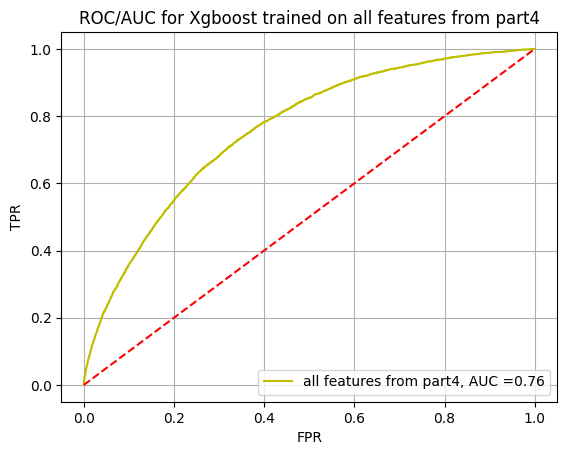

In [244]:
val_res_2 = xgboost2.predict_proba(val_X_2)
fpr,tpr,threshold,roc_auc_score = roc_auc_plot(val_Y_2,val_res_2,'Xgboost','all features from part4')
exp.log_figure(figure_name='ROC/AUC Xgboost trained on all features from part4 with hp tuning')

In [245]:
metrics_2 = {
    'class_probabilities':val_res_2,
    'validation_accuracy': metrics.accuracy_score(xgboost2.predict(train_X_2),train_Y_2),
    'AUC_score':roc_auc_score,
             }
exp.log_metrics(metrics_2, step=1)

COMET WARNING: Cannot safely convert array([[0.9188559 , 0.08114412],
       [0.9248735 , 0.07512654],
       [0.8082413 , 0.1917587 ],
       ...,
       [0.9476324 , 0.0523676 ],
       [0.81633604, 0.18366396],
       [0.9312438 , 0.06875622]], dtype=float32) object to a scalar value, using its string representation for logging. Resulting string might be invalid


In [246]:
probas_and_label_2 = helper_df(val_Y_2,val_res_2)
probas_and_label_2

,is_goal,goal_proba,#goal+#shot,#goal,#goal/#goal+#shot,rank,goal_prob_sum,goal_prob_cumulative_sum,cum_percent
55356,1,0.861009,1,0.0,0.000000,100.000000,1.389713e+06,0.000000e+00,0.000000
34900,0,0.846654,2,1.0,50.000000,99.998692,1.389713e+06,5.000000e+01,0.003598
66365,0,0.813631,3,1.0,33.333333,99.997384,1.389713e+06,8.333333e+01,0.005996
91648,1,0.800089,4,1.0,25.000000,99.996076,1.389713e+06,1.083333e+02,0.007795
89715,1,0.798530,5,2.0,40.000000,99.994768,1.389713e+06,1.483333e+02,0.010674
...,...,...,...,...,...,...,...,...,...
27922,0,0.007562,76450,7229.0,9.455853,0.006540,1.389713e+06,1.389676e+06,99.997278
166078,0,0.007177,76451,7229.0,9.455730,0.005232,1.389713e+06,1.389685e+06,99.997959
35767,0,0.006992,76452,7229.0,9.455606,0.003924,1.389713e+06,1.389694e+06,99.998639
140923,0,0.006975,76453,7229.0,9.455482,0.001962,1.389713e+06,1.389704e+06,99.999320


{'web': 'https://www.comet.com/api/image/download?imageId=0d639ad34bd6436ba0673525e734ab7f&experimentKey=cd4cdf2f3d6a47dc8a58b25261ed7c27',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=0d639ad34bd6436ba0673525e734ab7f&experimentKey=cd4cdf2f3d6a47dc8a58b25261ed7c27',
 'imageId': '0d639ad34bd6436ba0673525e734ab7f'}

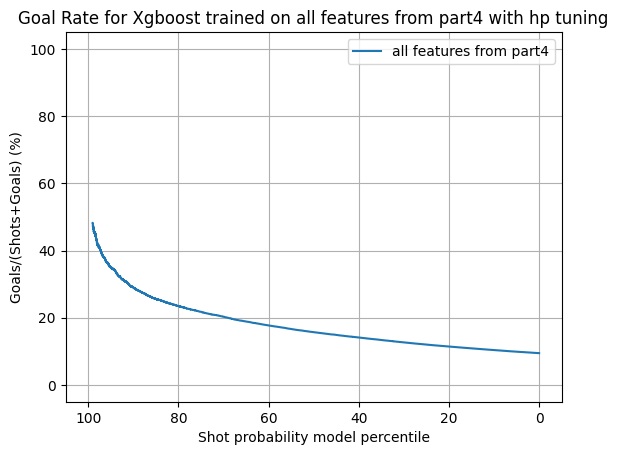

In [247]:
start_length = int(len(probas_and_label_2)*0.01)
plt.plot(probas_and_label_2['rank'].iloc[start_length:],probas_and_label_2['#goal/#goal+#shot'].iloc[start_length:],label="all features from part4")
plt.title(f'Goal Rate for Xgboost trained on all features from part4 with hp tuning')
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Goals/(Shots+Goals) (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()
exp.log_figure(figure_name='Goal Rate for Xgboost trained on all features from part4 with hp tuning')

{'web': 'https://www.comet.com/api/image/download?imageId=64c5b6da1fab423cab9d8e0e39955548&experimentKey=cd4cdf2f3d6a47dc8a58b25261ed7c27',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=64c5b6da1fab423cab9d8e0e39955548&experimentKey=cd4cdf2f3d6a47dc8a58b25261ed7c27',
 'imageId': '64c5b6da1fab423cab9d8e0e39955548'}

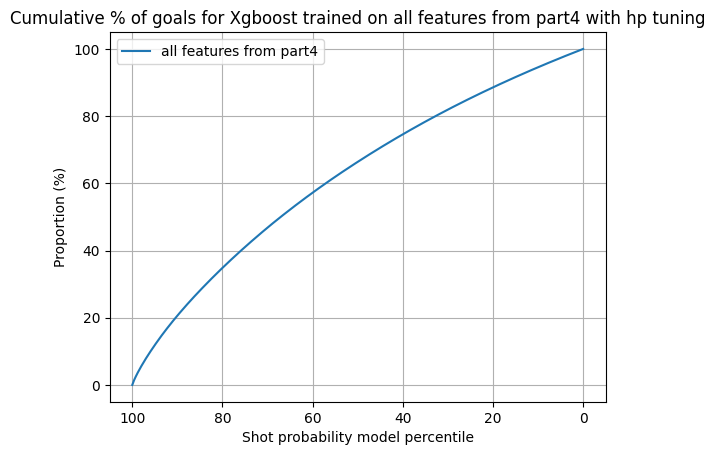

In [248]:
plt.plot(probas_and_label_2['rank'],probas_and_label_2['cum_percent'],label="all features from part4")
plt.title(f'Cumulative % of goals for Xgboost trained on all features from part4 with hp tuning')
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Proportion (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()
exp.log_figure(figure_name=f'Cumulative % of goals for Xgboost trained on all features from part4 with hp tuning')

{'web': 'https://www.comet.com/api/image/download?imageId=0a40632fee284482b60a1499a6cdb703&experimentKey=cd4cdf2f3d6a47dc8a58b25261ed7c27',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=0a40632fee284482b60a1499a6cdb703&experimentKey=cd4cdf2f3d6a47dc8a58b25261ed7c27',
 'imageId': '0a40632fee284482b60a1499a6cdb703'}

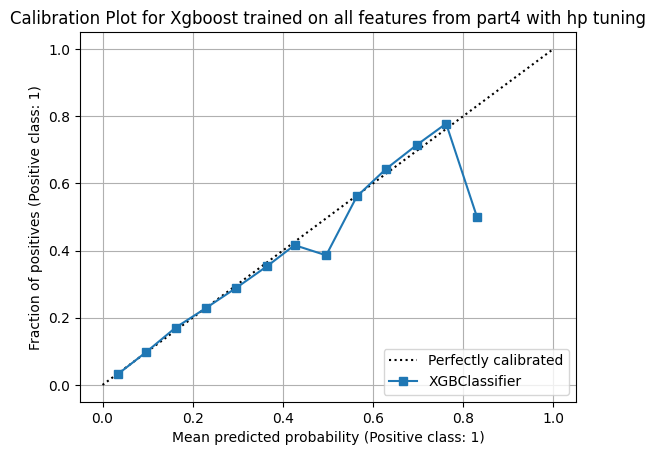

In [249]:
disp = CalibrationDisplay.from_estimator(xgboost2,val_X_2,val_Y_2,n_bins=15)
plt.title("Calibration Plot for Xgboost trained on all features from part4 with hp tuning")
plt.grid(True)
exp.log_figure(figure_name="Calibration Plot for Xgboost trained on all features from part4 with hp tuning")

In [250]:
exp.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/hfereidouni/ift6758/cd4cdf2f3d6a47dc8a58b25261ed7c27
COMET INFO:   Metrics:
COMET INFO:     AUC_score           : 0.7597431086549447
COMET INFO:     class_probabilities : [[0.9188559  0.08114412]
 [0.9248735  0.07512654]
 [0.8082413  0.1917587 ]
 ...
 [0.9476324  0.0523676 ]
 [0.81633604 0.18366396]
 [0.9312438  0.06875622]]
COMET INFO:     validation_accuracy : 0.9066009766306243
COMET INFO:   Parameters:
COMET INFO:     alpha                       : 1e-06
COMET INFO:     colsample_bytree            : 0.8323568311717368
COMET INFO:     copy_X_train                : True
COMET INFO:     eta                         : 0.8567846438

### 3. Train with **feature selection**

###### ref:
https://scikit-learn.org/stable/modules/feature_selection.html


In [251]:
# Create an experiment with your api key
exp = Experiment(
    api_key="v5q8O8LftZtvOcoXlVM8Ku8fH",
    project_name="ift6758",
    workspace="hfereidouni",
)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: xgboost, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/hfereidouni/ift6758/f0d489c19d4b471288372809a4cd8ff6



In [252]:
from sklearn.feature_selection import VarianceThreshold,RFE,SelectFromModel
from xgboost import plot_importance

##### a. Filter out low variance features

In [253]:
xgboost2_pretrained = XGBClassifier(**best_param)

In [254]:
t = 0.8*(1-0.8)
selector_1 = VarianceThreshold(t)
values = selector_1.fit_transform(train_X_2)
selector_1.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True, False, False, False, False, False, False,
        True, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [255]:
train_X_3_filtered = train_X_2.loc[:,selector_1.get_support()]
val_X_3_filtered = val_X_2.loc[:,selector_1.get_support()]

In [256]:
val_X_3_filtered

,game_time,period,x,y,x_coord_last_event,y_coord_last_event,Time_from_the_last_event,Distance_from_the_last_event,change_shot_angle,Speed,angle_net,shot_type_Wrist Shot,last_event_type_Faceoff
173380,337,1,-88.0,6.0,53.0,-39.0,3,148.006757,NaN,49.335586,-80.000000,0,0
145571,1220,3,63.0,-24.0,47.0,23.0,8,49.648766,NaN,6.206096,-42.000000,0,0
212619,744,2,82.0,-3.0,47.0,-40.0,9,50.931326,NaN,5.659036,-23.000000,1,0
153970,278,3,-69.0,27.0,26.0,16.0,11,95.634722,-45.550405,8.694066,-53.000000,1,0
224107,1046,3,66.0,31.0,36.0,-20.0,4,59.169249,NaN,14.792312,53.000000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
302897,903,3,-80.0,-1.0,-66.0,-13.0,9,18.439089,NaN,2.048788,6.000000,0,0
63705,1119,2,79.0,18.0,39.0,-27.0,12,60.207973,NaN,5.017331,60.945396,1,0
100964,87,1,69.0,22.0,34.0,-39.0,7,70.327804,NaN,10.046829,47.000000,1,0
86711,710,1,68.0,8.0,80.0,-1.0,1,15.000000,27.194650,15.000000,20.000000,1,0


In [257]:
xgboost_3_1 = xgboost2_pretrained.fit(train_X_3_filtered,train_Y_2)

In [258]:
xgboost_3_1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8323568311717368, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.8567846438831822, eval_metric=None, feature_types=None,
              gamma=8.017643442123559, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.30509960653055945,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=71, max_leaves=None,
              min_child_weight=8.911937758888639, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=53,
              n_jobs=None, num_parallel_tree=None, ...)

In [259]:
val_res_3_1=xgboost_3_1.predict_proba(val_X_3_filtered)[:,1]
auc_3_1 = metrics.roc_auc_score(val_Y_2,val_res_3_1)
auc_3_1

0.750622332374703

##### b.Recursive Feature Elimination(Wrapper method)

In [260]:
n_feature_in = len(train_X_2.columns)
n_feature_out = len(train_X_3_filtered.columns)

In [261]:
selector_2  = RFE(xgboost2_pretrained, n_features_to_select=n_feature_out, step=1)
selector_2= selector_2.fit(train_X_2,train_Y_2)

In [262]:
train_X_3_rfe = train_X_2.loc[:,selector_2.support_]
val_X_3_rfe = val_X_2.loc[:,selector_2.support_]
train_X_3_rfe

,game_time,period,x,y,Time_from_the_last_event,Rebound,change_shot_angle,Speed,angle_net,shot_type_Wrap-around,last_event_type_Faceoff,last_event_type_Hit,last_event_type_Stoppage
247975,549,2,79.0,3.0,1,True,10.240428,43.104524,16.00000,0,0,0,0
262354,323,1,12.0,33.0,8,False,NaN,10.371234,23.00000,0,0,1,0
230890,476,3,-76.0,-18.0,25,False,NaN,2.752744,54.00000,0,1,0,0
62112,749,3,70.0,-17.0,1,False,NaN,27.586228,-41.82017,0,0,1,0
184360,970,3,-37.0,-17.0,11,False,NaN,4.586181,18.00000,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
122579,1178,3,55.0,-23.0,45,False,NaN,3.336961,0.00000,0,0,0,0
304137,632,3,48.0,31.0,16,False,NaN,8.027784,37.00000,0,1,0,0
152315,1011,3,9.0,21.0,9,False,NaN,2.538591,-12.00000,0,1,0,0
117952,1127,2,74.0,-21.0,14,False,NaN,5.296321,-54.00000,0,0,0,0


In [263]:
xgboost_3_2 = xgboost2_pretrained.fit(train_X_3_rfe,train_Y_2)

In [264]:
val_res_3_2=xgboost_3_2.predict_proba(val_X_3_rfe)[:,1]
auc_3_2 = metrics.roc_auc_score(val_Y_2,val_res_3_2)
auc_3_2

0.752583207728232

##### L1-based feature selection

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

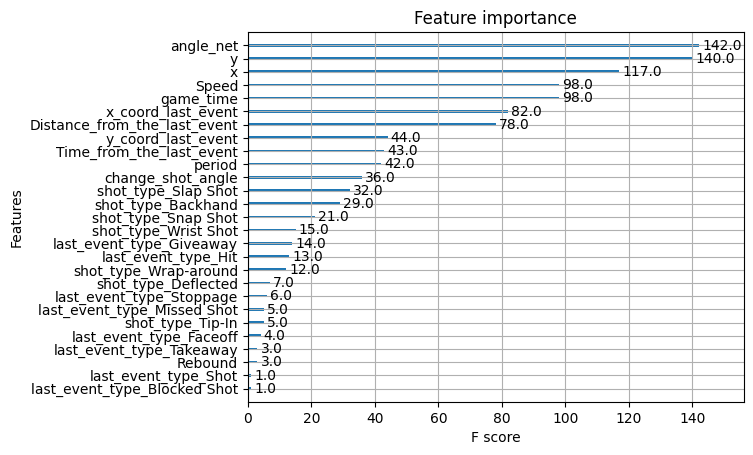

In [265]:
plot_importance(xgboost2)

In [266]:
selector3 = SelectFromModel(xgboost2,prefit=True)

In [267]:
X_new = selector3.fit_transform(train_X_2)

In [268]:
train_X_3_sfm=train_X_2.loc[:,selector3.get_support()]
val_X_3_sfm=val_X_2.loc[:,selector3.get_support()]

In [269]:
xgboost_3_3 = xgboost2_pretrained.fit(train_X_3_sfm,train_Y_2)

In [270]:
val_res_3_3=xgboost_3_3.predict_proba(val_X_3_sfm)[:,1]
auc_3_3 = metrics.roc_auc_score(val_Y_2,val_res_3_3)

In [271]:
auc_3_3

0.7387505973017772

{'web': 'https://www.comet.com/api/image/download?imageId=ee4f3b89db3d42ba88cacd6c49f9fe37&experimentKey=f0d489c19d4b471288372809a4cd8ff6',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=ee4f3b89db3d42ba88cacd6c49f9fe37&experimentKey=f0d489c19d4b471288372809a4cd8ff6',
 'imageId': 'ee4f3b89db3d42ba88cacd6c49f9fe37'}

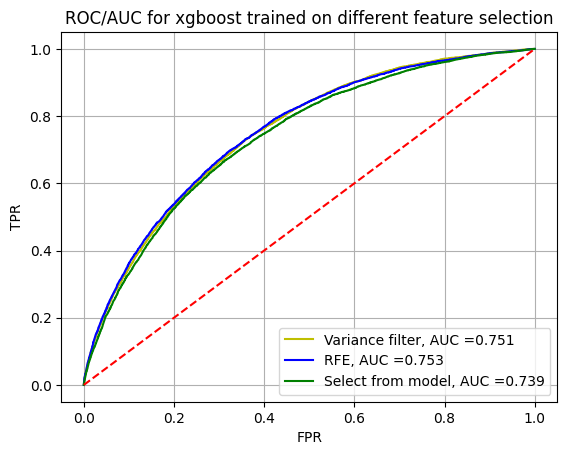

In [272]:
fpr_3_1,tpr_3_1,threshold_3_1 = metrics.roc_curve(val_Y_2,val_res_3_1)
fpr_3_2,tpr_3_2,threshold_3_2 = metrics.roc_curve(val_Y_2,val_res_3_2)
fpr_3_3,tpr_3_3,threshold_3_3 = metrics.roc_curve(val_Y_2,val_res_3_3)

auc_3_1 = metrics.auc(fpr_3_1,tpr_3_1)
auc_3_2 = metrics.auc(fpr_3_2,tpr_3_2)
auc_3_3 = metrics.auc(fpr_3_3,tpr_3_3)

plt.title(f'ROC/AUC for xgboost trained on different feature selection')
plt.plot(fpr_3_1,tpr_3_1,'y',label=f"Variance filter, AUC =%0.3f"%auc_3_1)
plt.plot(fpr_3_2,tpr_3_2,'b',label=f"RFE, AUC =%0.3f"%auc_3_2)
plt.plot(fpr_3_3,tpr_3_3,'g',label=f"Select from model, AUC =%0.3f"%auc_3_3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.grid(True)
plt.legend(loc="lower right")
exp.log_figure(figure_name='ROC/AUC for xgboost trained on different feature selection')

##### Filter method is faster and as good as RFE method, we will choose these features and do hyperparam tuning

##### No hyperparameter Tuning

In [273]:
train_X_3_selected = train_X_3_filtered.copy()

In [274]:
xgboost3 = xgboost2_pretrained.fit(train_X_3_selected,train_Y_2)

In [275]:
predict_proba3 = xgboost3.predict_proba(val_X_3_filtered)
val_res_3 = predict_proba3[:,1]

{'web': 'https://www.comet.com/api/image/download?imageId=0139759dea974a618a376ce0c58c5ef9&experimentKey=f0d489c19d4b471288372809a4cd8ff6',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=0139759dea974a618a376ce0c58c5ef9&experimentKey=f0d489c19d4b471288372809a4cd8ff6',
 'imageId': '0139759dea974a618a376ce0c58c5ef9'}

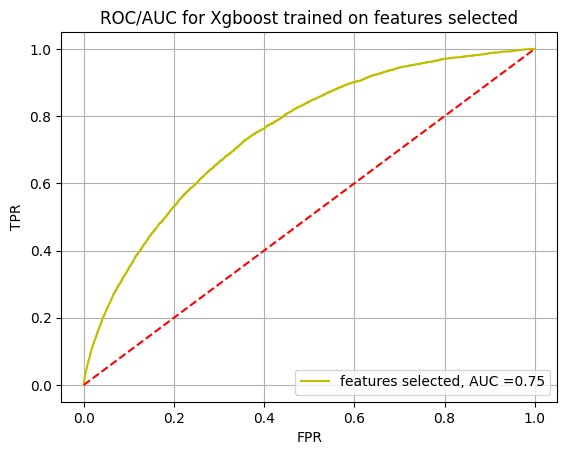

In [276]:
fpr,tpr,threshold,roc_auc_score = roc_auc_plot(val_Y_2,predict_proba3,'Xgboost','features selected')
exp.log_figure(figure_name='ROC/AUC for xgboost trained with feature selection no hp tuning')

In [278]:
probas_and_label_3 = helper_df(val_Y_2,predict_proba3)
probas_and_label_3

,is_goal,goal_proba,#goal+#shot,#goal,#goal/#goal+#shot,rank,goal_prob_sum,goal_prob_cumulative_sum,cum_percent
34900,0,0.855516,1,0.0,0.000000,100.000000,1.362248e+06,0.000000e+00,0.000000
290422,1,0.822498,2,0.0,0.000000,99.998692,1.362248e+06,0.000000e+00,0.000000
89715,1,0.783837,3,1.0,33.333333,99.997384,1.362248e+06,3.333333e+01,0.002447
204409,1,0.780101,4,2.0,50.000000,99.996076,1.362248e+06,8.333333e+01,0.006117
269142,1,0.774048,5,3.0,60.000000,99.994768,1.362248e+06,1.433333e+02,0.010522
...,...,...,...,...,...,...,...,...,...
286055,0,0.006440,76450,7229.0,9.455853,0.006540,1.362248e+06,1.362210e+06,99.997224
107065,0,0.006296,76451,7229.0,9.455730,0.004578,1.362248e+06,1.362220e+06,99.997918
170297,0,0.006296,76452,7229.0,9.455606,0.004578,1.362248e+06,1.362229e+06,99.998612
27922,0,0.006072,76453,7229.0,9.455482,0.002616,1.362248e+06,1.362239e+06,99.999306


{'web': 'https://www.comet.com/api/image/download?imageId=b82b1170516d4e848dc93d4484accfe1&experimentKey=f0d489c19d4b471288372809a4cd8ff6',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=b82b1170516d4e848dc93d4484accfe1&experimentKey=f0d489c19d4b471288372809a4cd8ff6',
 'imageId': 'b82b1170516d4e848dc93d4484accfe1'}

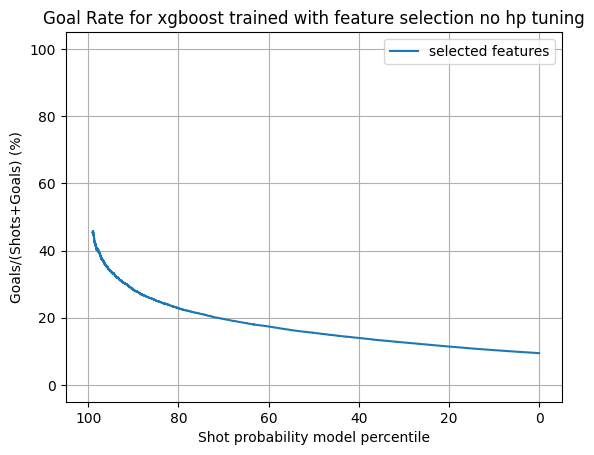

In [279]:
start_length = int(len(probas_and_label_3)*0.01)
plt.plot(probas_and_label_3['rank'].iloc[start_length:],probas_and_label_3['#goal/#goal+#shot'].iloc[start_length:],label="selected features")
plt.title(f'Goal Rate for xgboost trained with feature selection no hp tuning')
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Goals/(Shots+Goals) (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()
exp.log_figure(figure_name='Goal Rate for xgboost trained with feature selection no hp tuning')

{'web': 'https://www.comet.com/api/image/download?imageId=99010673b83b4643a10953ab5c48f946&experimentKey=f0d489c19d4b471288372809a4cd8ff6',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=99010673b83b4643a10953ab5c48f946&experimentKey=f0d489c19d4b471288372809a4cd8ff6',
 'imageId': '99010673b83b4643a10953ab5c48f946'}

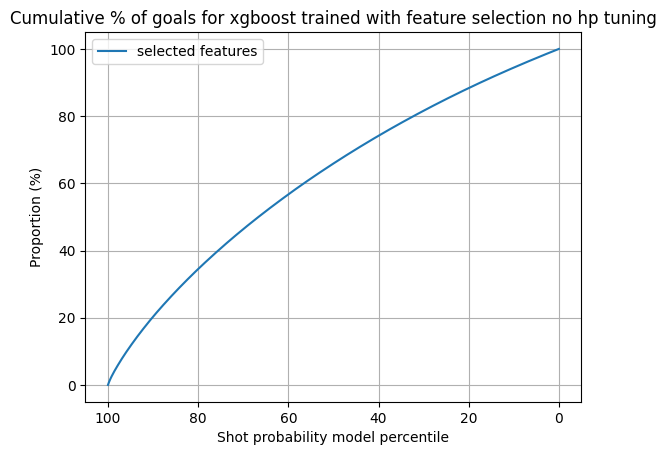

In [280]:
plt.plot(probas_and_label_3['rank'],probas_and_label_3['cum_percent'],label="selected features")
plt.title(f'Cumulative % of goals for xgboost trained with feature selection no hp tuning')
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Proportion (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()
exp.log_figure(figure_name=f'Cumulative % of goals for xgboost trained with feature selection no hp tuning')

{'web': 'https://www.comet.com/api/image/download?imageId=334b3e3b16df4b3593c00468fa5ddd24&experimentKey=f0d489c19d4b471288372809a4cd8ff6',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=334b3e3b16df4b3593c00468fa5ddd24&experimentKey=f0d489c19d4b471288372809a4cd8ff6',
 'imageId': '334b3e3b16df4b3593c00468fa5ddd24'}

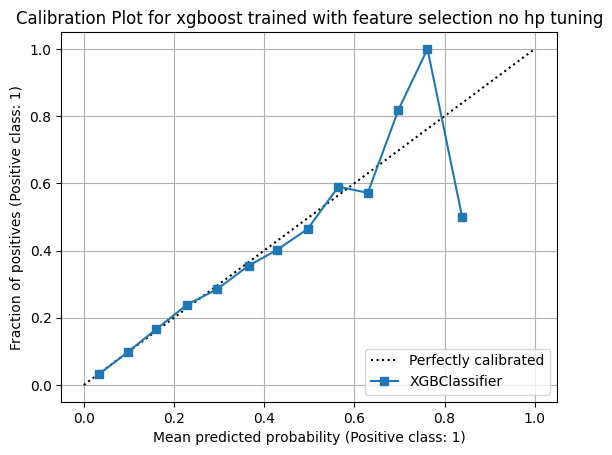

In [281]:
disp = CalibrationDisplay.from_estimator(xgboost_3_1,val_X_3_filtered,val_Y_2,n_bins=15)
plt.title("Calibration Plot for xgboost trained with feature selection no hp tuning")
plt.grid(True)
exp.log_figure(figure_name=f'Calibration Plot for xgboost trained with feature selection no hp tuning')

In [282]:
dump(xgboost3,'./models/xgboost3.joblib')

['./models/xgboost3.joblib']

In [283]:
xgboost3_path='./models/xgboost3.joblib'
exp.log_model('xgboost trained with feature selection no hp tuning','./models/xgboost3.joblib')

{'web': 'https://www.comet.com/api/asset/download?assetId=e0a1ac07bac64d18ad92806490b11938&experimentKey=f0d489c19d4b471288372809a4cd8ff6',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=e0a1ac07bac64d18ad92806490b11938&experimentKey=f0d489c19d4b471288372809a4cd8ff6',
 'assetId': 'e0a1ac07bac64d18ad92806490b11938'}

In [284]:
xgboost3 = load('./models/xgboost3.joblib')
val_y_3_filtered_hat = xgboost3.predict(val_X_3_filtered)

In [285]:

metrics_3 = {
    'class_probabilities':val_res_3,
    'validation_accuracy': metrics.accuracy_score(val_y_3_filtered_hat,val_Y_2),
    'AUC_score':roc_auc_score,
             }
exp.log_metrics(metrics_3, step=1)

COMET WARNING: Cannot safely convert array([0.11341651, 0.08348335, 0.15964127, ..., 0.04895693, 0.18507387,
       0.10384446], dtype=float32) object to a scalar value, using its string representation for logging. Resulting string might be invalid


In [286]:
exp.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/hfereidouni/ift6758/f0d489c19d4b471288372809a4cd8ff6
COMET INFO:   Metrics:
COMET INFO:     AUC_score           : 0.750622332374703
COMET INFO:     class_probabilities : [0.11341651 0.08348335 0.15964127 ... 0.04895693 0.18507387 0.10384446]
COMET INFO:     validation_accuracy : 0.9060350014387737
COMET INFO:   Parameters:
COMET INFO:     estimator                          : XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8323568311717368, device=None,
              early_stopping_rounds=None, enable_categorical=False,
    

COMET INFO:     estimator__grow_policy             : 1
COMET INFO:     estimator__importance_type         : 1
COMET INFO:     estimator__interaction_constraints : 1
COMET INFO:     estimator__learning_rate           : 0.30509960653055945
COMET INFO:     estimator__max_bin                 : 1
COMET INFO:     estimator__max_cat_threshold       : 1
COMET INFO:     estimator__max_cat_to_onehot       : 1
COMET INFO:     estimator__max_delta_step          : 1
COMET INFO:     estimator__max_depth               : 71
COMET INFO:     estimator__max_leaves              : 1
COMET INFO:     estimator__min_child_weight        : 8.911937758888639
COMET INFO:     estimator__missing                 : nan
COMET INFO:     estimator__monotone_constraints    : 1
COMET INFO:     estimator__multi_strategy          : 1
COMET INFO:     estimator__n_estimators            : 53
COMET INFO:     estimator__n_jobs                  : 1
COMET INFO:     estimator__num_parallel_tree       : 1
COMET INFO:     estimator__

##### With Hyperparameter tuning

In [287]:
# Create an experiment with your api key
exp = Experiment(
    api_key="v5q8O8LftZtvOcoXlVM8Ku8fH",
    project_name="ift6758",
    workspace="hfereidouni",
)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: xgboost, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/hfereidouni/ift6758/caa6b53d724c41c9a001be6440449b52



In [288]:
def xgboost_opti_2(learning_rate,max_depth,min_child_weight,subsample,colsample_bytree,gamma,eta,n_estimators):

    xgb = XGBClassifier(learning_rate=learning_rate,
        max_depth=int(max_depth),
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree= colsample_bytree,
        gamma=gamma,
        eta=eta,
        n_estimators=int(n_estimators))

    cv_score = cross_val_score(xgb,train_X_3_selected,train_Y_2,cv=3,scoring='roc_auc')
    
    return cv_score.mean()

xgb_bo_2 = BayesianOptimization(f=xgboost_opti_2,pbounds=params,random_state=1)

In [289]:
xgb_bo_2.maximize()

|   iter    |  target   | colsam... |    eta    |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.6755    | 0.417     | 0.7203    | 0.001144  | 0.3023    | 14.68     | 0.9234    | 59.31     | 0.3456    |
| 2         | 0.7259    | 0.3968    | 0.5388    | 4.192     | 0.6852    | 20.45     | 8.781     | 51.37     | 0.6705    |
| 3         | 0.7228    | 0.4173    | 0.5587    | 1.404     | 0.1981    | 80.07     | 9.683     | 65.67     | 0.6923    |
| 4         | 0.7461    | 0.8764    | 0.8946    | 0.8504    | 0.03905   | 16.98     | 8.781     | 54.92     | 0.4211    |
| 5         | 0.7464    | 0.9579    | 0.5332    | 6.919     | 0.3155    | 68.65     | 8.346     | 50.91     | 0.7501    |
| 6         | 0.7375    | 0.2305    | 0.4031    | 6.868     | 0.4325    | 69.6      | 8.523     | 51.94     | 0.8765    |
| 7         | 0.718     

In [290]:
best_param_2 = xgb_bo_2.max['params']
best_param_2['n_estimators'] = int(best_param['n_estimators'])
best_param_2['max_depth'] = int(best_param['max_depth'])
best_param_2

{'colsample_bytree': 0.5647838996766793,
 'eta': 0.8086508162843394,
 'gamma': 9.73763558347701,
 'learning_rate': 0.0899607131650827,
 'max_depth': 71,
 'min_child_weight': 3.0710104703310384,
 'n_estimators': 53,
 'subsample': 0.7479929230375024}

In [291]:
exp.log_parameters(best_param_2)

In [292]:
xgboost4 = XGBClassifier(**best_param_2)

In [293]:
xgboost4 = xgboost4.fit(train_X_3_selected,train_Y_2)

In [294]:
dump(xgboost4,'./models/xgboost4.joblib')
xgboost4_path='./models/xgboost4.joblib'
exp.log_model('xgboost trained with features selected and hp tuned','./models/xgboost4.joblib')

{'web': 'https://www.comet.com/api/asset/download?assetId=d580b27f8c5e4c93a27e3202aff03117&experimentKey=caa6b53d724c41c9a001be6440449b52',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=d580b27f8c5e4c93a27e3202aff03117&experimentKey=caa6b53d724c41c9a001be6440449b52',
 'assetId': 'd580b27f8c5e4c93a27e3202aff03117'}

{'web': 'https://www.comet.com/api/image/download?imageId=48def2c398bd423dac26498845a97104&experimentKey=caa6b53d724c41c9a001be6440449b52',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=48def2c398bd423dac26498845a97104&experimentKey=caa6b53d724c41c9a001be6440449b52',
 'imageId': '48def2c398bd423dac26498845a97104'}

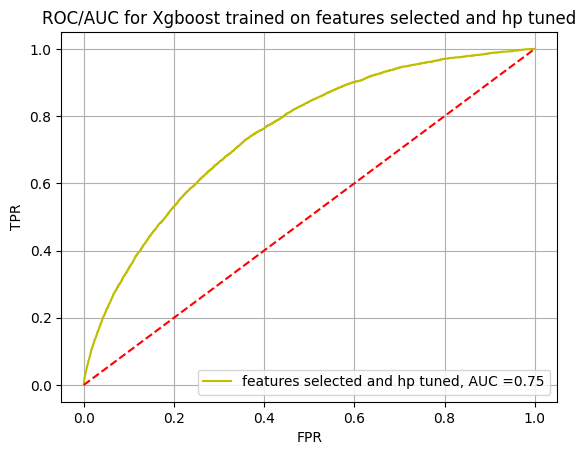

In [295]:
val_res_4 = xgboost3.predict_proba(val_X_3_filtered)
fpr,tpr,threshold,roc_auc_score = roc_auc_plot(val_Y_2,val_res_4,'Xgboost','features selected and hp tuned')
exp.log_figure(figure_name='ROC/AUC for xgboost trained with features selected and hp tuned')

In [296]:
val_y_4_filtered_hat = xgboost4.predict(val_X_3_filtered)
metrics_4 = {
    'class_probabilities':val_res_4,
    'validation_accuracy': metrics.accuracy_score(val_y_4_filtered_hat,val_Y_2),
    'AUC_score':roc_auc_score,
             }
exp.log_metrics(metrics_4, step=1)

COMET WARNING: Cannot safely convert array([[0.8865835 , 0.11341651],
       [0.91651666, 0.08348335],
       [0.84035873, 0.15964127],
       ...,
       [0.95104307, 0.04895693],
       [0.81492615, 0.18507387],
       [0.89615554, 0.10384446]], dtype=float32) object to a scalar value, using its string representation for logging. Resulting string might be invalid


In [297]:
probas_and_label_4 = helper_df(val_Y_2,val_res_4)
probas_and_label_4

,is_goal,goal_proba,#goal+#shot,#goal,#goal/#goal+#shot,rank,goal_prob_sum,goal_prob_cumulative_sum,cum_percent
34900,0,0.855516,1,0.0,0.000000,100.000000,1.362248e+06,0.000000e+00,0.000000
290422,1,0.822498,2,0.0,0.000000,99.998692,1.362248e+06,0.000000e+00,0.000000
89715,1,0.783837,3,1.0,33.333333,99.997384,1.362248e+06,3.333333e+01,0.002447
204409,1,0.780101,4,2.0,50.000000,99.996076,1.362248e+06,8.333333e+01,0.006117
269142,1,0.774048,5,3.0,60.000000,99.994768,1.362248e+06,1.433333e+02,0.010522
...,...,...,...,...,...,...,...,...,...
286055,0,0.006440,76450,7229.0,9.455853,0.006540,1.362248e+06,1.362210e+06,99.997224
107065,0,0.006296,76451,7229.0,9.455730,0.004578,1.362248e+06,1.362220e+06,99.997918
170297,0,0.006296,76452,7229.0,9.455606,0.004578,1.362248e+06,1.362229e+06,99.998612
27922,0,0.006072,76453,7229.0,9.455482,0.002616,1.362248e+06,1.362239e+06,99.999306


{'web': 'https://www.comet.com/api/image/download?imageId=556963dd81b04076b346ab85695f5b9c&experimentKey=caa6b53d724c41c9a001be6440449b52',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=556963dd81b04076b346ab85695f5b9c&experimentKey=caa6b53d724c41c9a001be6440449b52',
 'imageId': '556963dd81b04076b346ab85695f5b9c'}

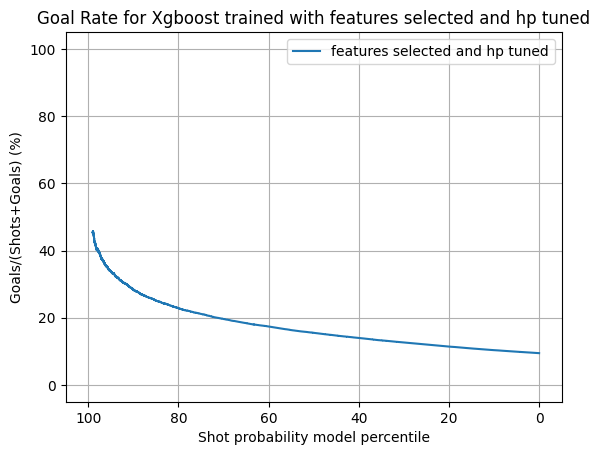

In [298]:
start_length = int(len(probas_and_label_4)*0.01)
plt.plot(probas_and_label_4['rank'].iloc[start_length:],probas_and_label_4['#goal/#goal+#shot'].iloc[start_length:],label='features selected and hp tuned')
plt.title(f'Goal Rate for Xgboost trained with features selected and hp tuned')
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Goals/(Shots+Goals) (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()
exp.log_figure(figure_name='Goal Rate for Xgboost trained with features selected and hp tuned')

{'web': 'https://www.comet.com/api/image/download?imageId=d0e0354c460341689b0e9c1103363f1a&experimentKey=caa6b53d724c41c9a001be6440449b52',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=d0e0354c460341689b0e9c1103363f1a&experimentKey=caa6b53d724c41c9a001be6440449b52',
 'imageId': 'd0e0354c460341689b0e9c1103363f1a'}

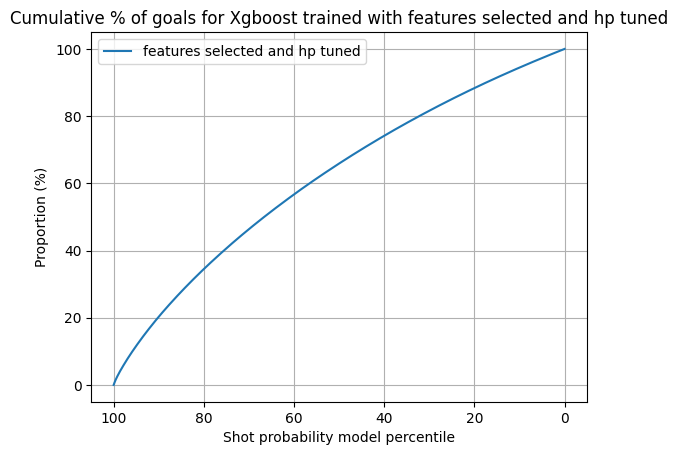

In [299]:
plt.plot(probas_and_label_4['rank'],probas_and_label_4['cum_percent'],label='features selected and hp tuned')
plt.title(f'Cumulative % of goals for Xgboost trained with features selected and hp tuned')
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Proportion (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()
exp.log_figure(figure_name=f'Cumulative % of goals for Xgboost trained ith features selected and hp tuned')

{'web': 'https://www.comet.com/api/image/download?imageId=a85f41d800b14b11b6ceeae71f5edbb2&experimentKey=caa6b53d724c41c9a001be6440449b52',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=a85f41d800b14b11b6ceeae71f5edbb2&experimentKey=caa6b53d724c41c9a001be6440449b52',
 'imageId': 'a85f41d800b14b11b6ceeae71f5edbb2'}

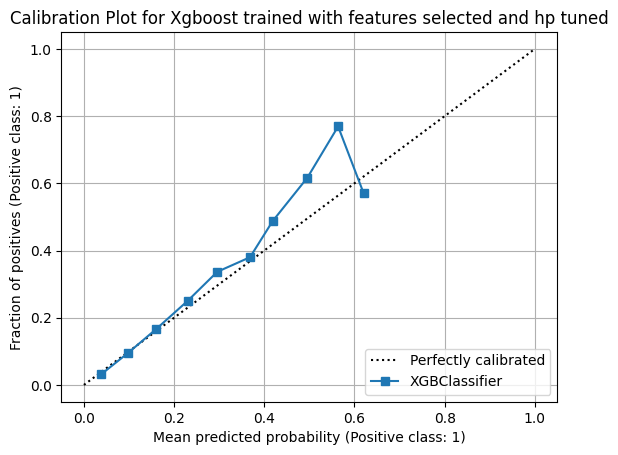

In [300]:
disp = CalibrationDisplay.from_estimator(xgboost4,val_X_3_filtered,val_Y_2,n_bins=15)
plt.title("Calibration Plot for Xgboost trained with features selected and hp tuned")
plt.grid(True)
exp.log_figure(figure_name="Calibration Plot for Xgboost trained with features selected and hp tuned")

In [301]:
exp.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/hfereidouni/ift6758/caa6b53d724c41c9a001be6440449b52
COMET INFO:   Metrics:
COMET INFO:     AUC_score           : 0.750622332374703
COMET INFO:     class_probabilities : [[0.8865835  0.11341651]
 [0.91651666 0.08348335]
 [0.84035873 0.15964127]
 ...
 [0.95104307 0.04895693]
 [0.81492615 0.18507387]
 [0.89615554 0.10384446]]
COMET INFO:     validation_accuracy : 0.905825725272713
COMET INFO:   Parameters:
COMET INFO:     alpha                       : 1e-06
COMET INFO:     colsample_bytree            : 0.5647838996766793
COMET INFO:     copy_X_train                : True
COMET INFO:     eta                         : 0.808650816284